# TP4 : Travail final

# Imports et configuration

In [124]:
from collections import defaultdict
import os
import sys
import collections
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

import yake
from collections import Counter
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display

import spacy
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from unidecode import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [125]:
path = "../data/tp4_txt/"
files = sorted(os.listdir(path))

temp_path = '../data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

In [126]:
## Créer un fichier unique

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in txts:
    with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
        content_list.append(f.read())

# Ecrire tout le contenu dans un fichier temporaire
with open(os.path.join(temp_path, f'tp4_all.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(content_list))

In [127]:
## Créer un fichier par journal

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Stocker le contenu de ces fichiers dans une liste
LaLibreBelgique_list = []
LePeuple_list = []
LeSoir_list = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):
        elems = txt.split("_")
        newspaper = elems[1]    
    
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if newspaper == "JB427": # La Libre
                LaLibreBelgique_list.append(f.read())

            if newspaper == "JB837": # Le Peuple
                LePeuple_list.append(f.read())

            if newspaper == "JB838": # Le Soir
                LeSoir_list.append(f.read())
    
    else:
        print(f"Anomalous file: {f}")

# Ecrire tout le contenu dans des fichiers temporaires par journaux
with open(os.path.join(temp_path, f'tp4_LaLibreBelgique.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LaLibreBelgique_list))
with open(os.path.join(temp_path, f'tp4_LePeuple.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LePeuple_list))
with open(os.path.join(temp_path, f'tp4_LeSoir.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LeSoir_list))

nomJournaux = ["tp4_LaLibreBelgique.txt", "tp4_LePeuple.txt", "tp4_LeSoir.txt"]

# Exploration du corpus

In [128]:
## Taille du corpus complet

print("Nombre de fichiers dans le corpus :", len(files))

Nombre de fichiers dans le corpus : 2035


## Par année et par journal

In [200]:
all_years = [str(year) for year in range(1919,1951)] # 1951 car exclusif

count_year = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

count_year_LLB = defaultdict(int)
count_year_LP = defaultdict(int)
count_year_LS = defaultdict(int)
covered_years_LLB = set()
covered_years_LP = set()
covered_years_LS = set()

for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        
        count_year[year] += 1
        count_newspapers[newspaper] += 1

        if newspaper == "JB427":
            covered_years_LLB.add(year)
            count_year_LLB[year] += 1
        if newspaper == "JB837":
            covered_years_LP.add(year)
            count_year_LP[year] += 1
        if newspaper == "JB838":
            covered_years_LS.add(year)
            count_year_LS[year] += 1

    else:
        print(f"Anomalous file: {f}")

In [348]:
print(f"Il y a {count_newspapers['JB427']} fichiers de La Libre Belgique, {count_newspapers['JB837']} fichiers du Peuple et {count_newspapers['JB838']} fichiers du Soir.")

Il y a 700 fichiers de La Libre Belgique, 553 fichiers du Peuple et 782 fichiers du Soir.


In [202]:
missing_years = [y for y in all_years if y not in covered_years]

if missing_years :
    print(f"Années manquantes: {', '.join(missing_years)}")
else:
    print("Pas d'années manquantes")

print("")

missing_years_LLB = [y for y in all_years if y not in covered_years_LLB]

if missing_years_LLB :
    print(f"Années manquantes dans La Libre Belgique : {', '.join(missing_years_LLB)}")
else:
    print("Pas d'années manquantes dans La Libre Belgique")

missing_years_LP = [y for y in all_years if y not in covered_years_LP]

if missing_years_LP :
    print(f"Années manquantes dans Le Peuple : {', '.join(missing_years_LP)}")
else:
    print("Pas d'années manquantes dans Le Peuple")

missing_years_LS = [y for y in all_years if y not in covered_years_LS]

if missing_years_LS :
    print(f"Années manquantes dans Le Soir : {', '.join(missing_years_LS)}")
else:
    print("Pas d'années manquantes dans Le Soir")

Pas d'années manquantes

Années manquantes dans La Libre Belgique : 1941, 1942, 1943, 1944
Années manquantes dans Le Peuple : 1941, 1942, 1943
Pas d'années manquantes dans Le Soir


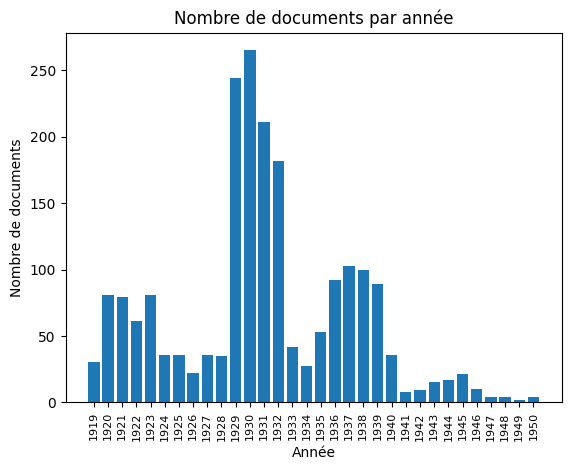

In [211]:
index = np.arange(len(count_year))
plt.bar(index, count_year.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année')
plt.show()

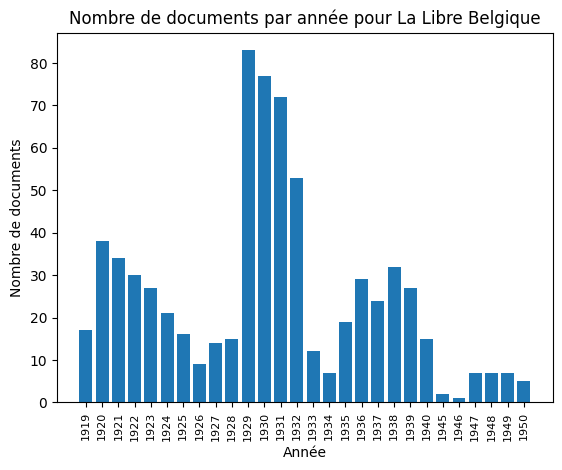

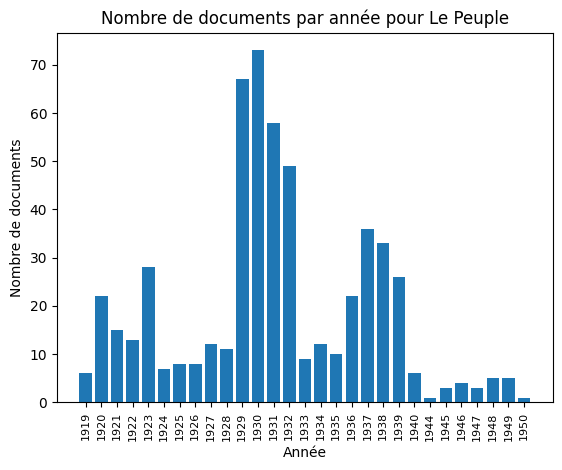

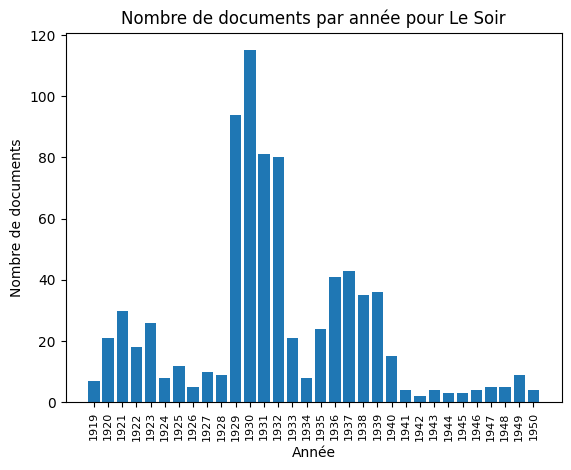

In [213]:
# Répartition dans les journaux

index = np.arange(len(count_year_LLB))
plt.bar(index, count_year_LLB.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year_LLB.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année pour La Libre Belgique')
plt.show()

index = np.arange(len(count_year_LP))
plt.bar(index, count_year_LP.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year_LP.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année pour Le Peuple')
plt.show()

index = np.arange(len(count_year_LS))
plt.bar(index, count_year_LS.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year_LS.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année pour Le Soir')
plt.show()

## Vocabulaire du corpus

In [133]:
limit = 10**8

with open(temp_path + "tp4_all.txt", "r", encoding="utf-8") as f:
    text = f.read()[:limit]

In [134]:
# Dresser la liste des stopwords

sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"
    ]
sw = set(sw)

In [135]:
# Tokenization
words = nltk.wordpunct_tokenize(text)
print(f"{len(words)} mots trouvés dans le corpus")

# Eliminer les stopwords et les termes non alphabétiques
kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
voc = set(kept)
print(f"{len(kept)} mots conservés après tri ({len(voc)} lemmes différents)")

17941543 mots trouvés dans le corpus
6332344 mots conservés après tri (489700 lemmes différents)


In [136]:
# Mots les plus fréquents et hapax

fdist = nltk.FreqDist(kept)
print("Mots les plus fréquents :", fdist.most_common(10))
print("--")
print("Hapax :", fdist.hapaxes()[:30])

Mots les plus fréquents : [('gouvernement', 19793), ('ministre', 16715), ('bruxelles', 15683), ('pays', 13905), ('question', 13686), ('belgique', 12761), ('président', 11365), ('conseil', 10556), ('politique', 10350), ('heures', 10320)]
--
Hapax : ['cenlimesiie', 'jstiition', 'fifdaelioh', 'arjiainlstrali', 'usoowdrkdltiondesjournaui', 'tihotk', 'herbeà', 'usq', 'coiultlori', 'tomlguos', 'tnanusci', 'rmctilt', 'ponltaîues', 'exnlustae', 'horeaui', 'hjilioii', 'uonm', 'aïence', 'tviu', 'puice', 'cfej', 'ngrs', 'disman', 'ltlsiliriie', 'onijistsilatb', 'vmuîs', 'dlvbî', 'itiali', 'kkgkoluduils', 'ekor']


# Mots-clés

In [137]:
# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

## Corpus complet

In [138]:
# Récupérer le texte temporaire complet, en mode lecture ('r'), en encodage utf-8
text = open(os.path.join(temp_path, f'tp4_all.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)

kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

Le fichier mentionne les mots-clés suivants (bigrammes) : VAN CAUWELAERT, Libre Belgique, PARIS Paris, van Zeeland, gouvernement belge, Société Nationale, défense nationale, Conseil général, LONDRES Londres, Mme Van, BRUXELLES BRUXELLES, Congo belge...
Le fichier mentionne les mots-clés suivants (trigrammes) : gouvernement van Zeeland, Parti ouvrier belge, jour LIBRE BELGIQUE, Ligue nationale belge, Anvers Bruxelles Gand, GRAND BRUXELLES Bruxelles, Chambre française Paris, Paul van Zeeland, parti socialiste belge, OUVRIER BELGE BRUXELLES, LIBRE BELGIQUE ANNONCES, Bruxelles CHAMBRE Catholiques, Bruxelles jeudi soir, SOCIALISTES BRUXELLES CHAMBRE, Bloc catholique belge, Société royale belge, Mgr Van Roey, Angleterre France Belgique, Bruxelles Jeudi Londres, Roi Albert Bruxelles, cardinal Van Roey, Comité National belge, Bruxelles Gand Charleroi, parti catholique belge, Bruxelles Mercredi soir, parti socialiste français, ministres catholiques flamands, Fédération royale belge, Bruxelles d

## Journal par journal

In [139]:
# Faire la même opération pour les trois fichiers par journal

for i in nomJournaux:
    text = open(os.path.join(temp_path, i), 'r', encoding="utf-8").read()

    keywords = kw_extractor.extract_keywords(text)
    kept_bi = []
    kept_tri = []

    for kw, score in keywords:
        words = kw.split()

        if len(words) == 2:
            kept_bi.append(kw)
        
        if len(words) == 3:
            kept_tri.append(kw)

    print(f"{i} mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
    print(f"{i} mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")
    print("---")

tp4_LaLibreBelgique.txt mentionne les mots-clés suivants (bigrammes) : Libre Belgique, VAN CAUWELAERT, parti catholique, gouvernement belge, van Zeeland, van den, défense nationale, Société Nationale, question linguistique, catholique belge, Banque Nationale, roi Albert, Mme Van, conseil communal, Mgr Van...
tp4_LaLibreBelgique.txt mentionne les mots-clés suivants (trigrammes) : jour LIBRE BELGIQUE, LIBRE BELGIQUE ANNONCES, Bruxelles CHAMBRE Catholiques, Bloc catholique belge, cardinal Van Roey, gouvernement van Zeeland, l'Union catholique belge, jeunesse catholique belge, parti catholique belge, ministres catholiques flamands, Bruxelles dimanche matin, cours d'une réunion, Roi Albert Bruxelles, Belgique Comité Catholique, Mgr Van Roey, Angleterre France Belgique, LIBRE BELGIQUE ABONNEMENTS, Mlle Van den, parti socialiste belge, ministre Van Isacker, LIBRE BELGIQUE VOIR, constitution d'une commission, Van den Eynde, cours d'une conférence, cours d'une séance...
---
tp4_LePeuple.txt men

## Exploration de trois périodes distinctes

In [140]:
# Explorer la période 1935-1940 qu'on repère sur le graphe du nbre de doc par année

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1935,1941)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1935-1940.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1935-1940.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

Le fichier mentionne les mots-clés suivants (bigrammes) : Van Zeeland, LIBRE BELGIQUE, défense nationale, parti catholique, Gouvernement belge, Banque Nationale, Conseil général, gouvernement van, Fédération nationale, Van Cauwelaert, PARIS Paris, roi Albert, Congo belge, Société nationale, catholique belge, Mme Van, LONDRES Londres, parti socialiste, Conseil National...
Le fichier mentionne les mots-clés suivants (trigrammes) : gouvernement van Zeeland, Parti Ouvrier Belge, Bloc catholique belge, Paul van Zeeland, jour LIBRE BELGIQUE, ministre van Zeeland, OUVRIER BELGE BRUXELLES, cabinet van Zeeland, LIGUE NATIONALE BELGE, parti catholique flamand, parti socialiste belge, Belgique Comité Catholique, Parti catholique social, Angleterre France Belgique, rapport van Zeeland, Mme Louis Van, van Zeeland s'est, Commission nationale mixte, Mme Henri Van, LIBRE BELGIQUE ANNONCES, parti catholique belge, Mme Georges Van...


In [141]:
# Idem pour la période 1919-1925

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1919, 1926)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1919-1925.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1919-1925.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

Le fichier mentionne les mots-clés suivants (bigrammes) : Libre Belgique, VAN CAUWELAERT, gouvernement belge, parti catholique, gouvernement allemand, parti socialiste, question linguistique, gouvernement français, peuple flamand, Lloyd George, nation belge, catholique belge, qu'il faut, Conseil général...
Le fichier mentionne les mots-clés suivants (trigrammes) : Parti ouvrier belge, GRAND BRUXELLES Bruxelles, parti socialiste belge, parti catholique belge, l'Union catholique belge, LIGUE NATIONALE BELGE, PARTI SOCIALISTE FRANÇAIS, LIBRE BELGIQUE ANNONCES, Bruxelles PETITES ANNONCES, jeunesse catholique belge, Chambre française Paris, qu'il faut faire, gouvernement belge vient, Bruxelles dimanche soir, Société Royale belge, groupe catholique flamand, GUERRE BELGE Londres...


In [142]:
# Idem pour la période 1929-1933

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1929, 1934)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1929-1933.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1929-1933.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

Le fichier mentionne les mots-clés suivants (bigrammes) : Van Cauwelaert, PARIS Paris, Libre Belgique, Société nationale, question linguistique, BRUXELLES BRUXELLES, gouvernement belge, conseil général, Mme Van, LONDRES Londres, conseil national, Congo Belge, Van den, Défense nationale, conseil communal...
Le fichier mentionne les mots-clés suivants (trigrammes) : Parti Ouvrier Belge, Anvers Bruxelles Gand, Bruxelles CHAMBRE Catholiques, Chambre française Paris, Ligue nationale belge, jour LIBRE BELGIQUE, Bruxelles Gand Charleroi, Bruxelles jeudi soir, ministres catholiques flamands, Sénat français Paris, Mme HANAU Paris, Chambre française Belgique, Mgr Van Roey, Conseil rue Van, Mme Van den, ALBERT LONDRES Paris, Parti socialiste belge, cardinal Van Roey, Conseil national socialiste, C’est Mme Van, ROI GEORGE Londres, Mme Joseph Van, Comité National belge, Bruxelles Mercredi soir, Bruxelles d'une Maison, LIBRE BELGIQUE ANNONCES, Bruxelles dimanche matin, cours d'une conférence...


# Nuages de mots

In [349]:
## Fonction de nettoyage

def clean_text(inFile, folder=None):
    if folder is None:
        input_path = f"{inFile}"
        output_path = f"clean_{inFile}"
    else:
        input_path = f"{folder}{inFile}"
        output_path = f"{folder}clean_{inFile}"

    output = open(output_path, "w", encoding='utf-8')

    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)

    return f'Output has been written in {output_path}!'

In [350]:
# Liste des stopwords

sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi", 
    # Coquilles + mots sans sémantiques discrimantes d'après les mots les plus fréquents
    "heures", "grand", "jour", "lieu", "temps", "grande", "part", "mois", "matin", "soir", "aujourd", "moment", "jours", "fois", "heure", "jamais", "également", "ailleurs", "hier", "vient", "année", "certains", "cependant", "parce"
    ]
sw = set(sw)

## Sur le corpus complet

In [351]:
# Appliquer la fonction et vérifier les résultats

clean_text("tp4_all.txt", folder=temp_path)

with open(os.path.join(temp_path, f'clean_tp4_all.txt'), 'r', encoding="utf-8") as f:
    after = f.read()

# Calculer les mots les plus fréquents et afficher les résultats

frequencies = Counter(after.split())

print(frequencies.most_common(100))

[('gouvernement', 19793), ('ministre', 16715), ('bruxelles', 15683), ('pays', 13905), ('question', 13686), ('belgique', 12761), ('président', 11365), ('conseil', 10556), ('politique', 10350), ('guerre', 10060), ('général', 9829), ('parti', 9480), ('cours', 9166), ('belge', 9045), ('chambre', 8980), ('prix', 8722), ('francs', 8701), ('ordre', 8583), ('commission', 8194), ('paris', 8173), ('projet', 8037), ('france', 8021), ('etat', 7914), ('premier', 7838), ('point', 7672), ('situation', 7612), ('travail', 7535), ('français', 7217), ('nationale', 6782), ('séance', 6551), ('socialistes', 6441), ('nouveau', 6197), ('comité', 6152), ('membres', 6094), ('millions', 6044), ('allemagne', 5860), ('droit', 5653), ('londres', 5616), ('accord', 5590), ('nouvelle', 5548), ('anvers', 5501), ('belges', 5372), ('socialiste', 5360), ('peuple', 5357), ('demande', 5351), ('partie', 5319), ('compte', 5301), ('société', 5257), ('première', 5246), ('catholique', 5155), ('conférence', 5053), ('service', 497

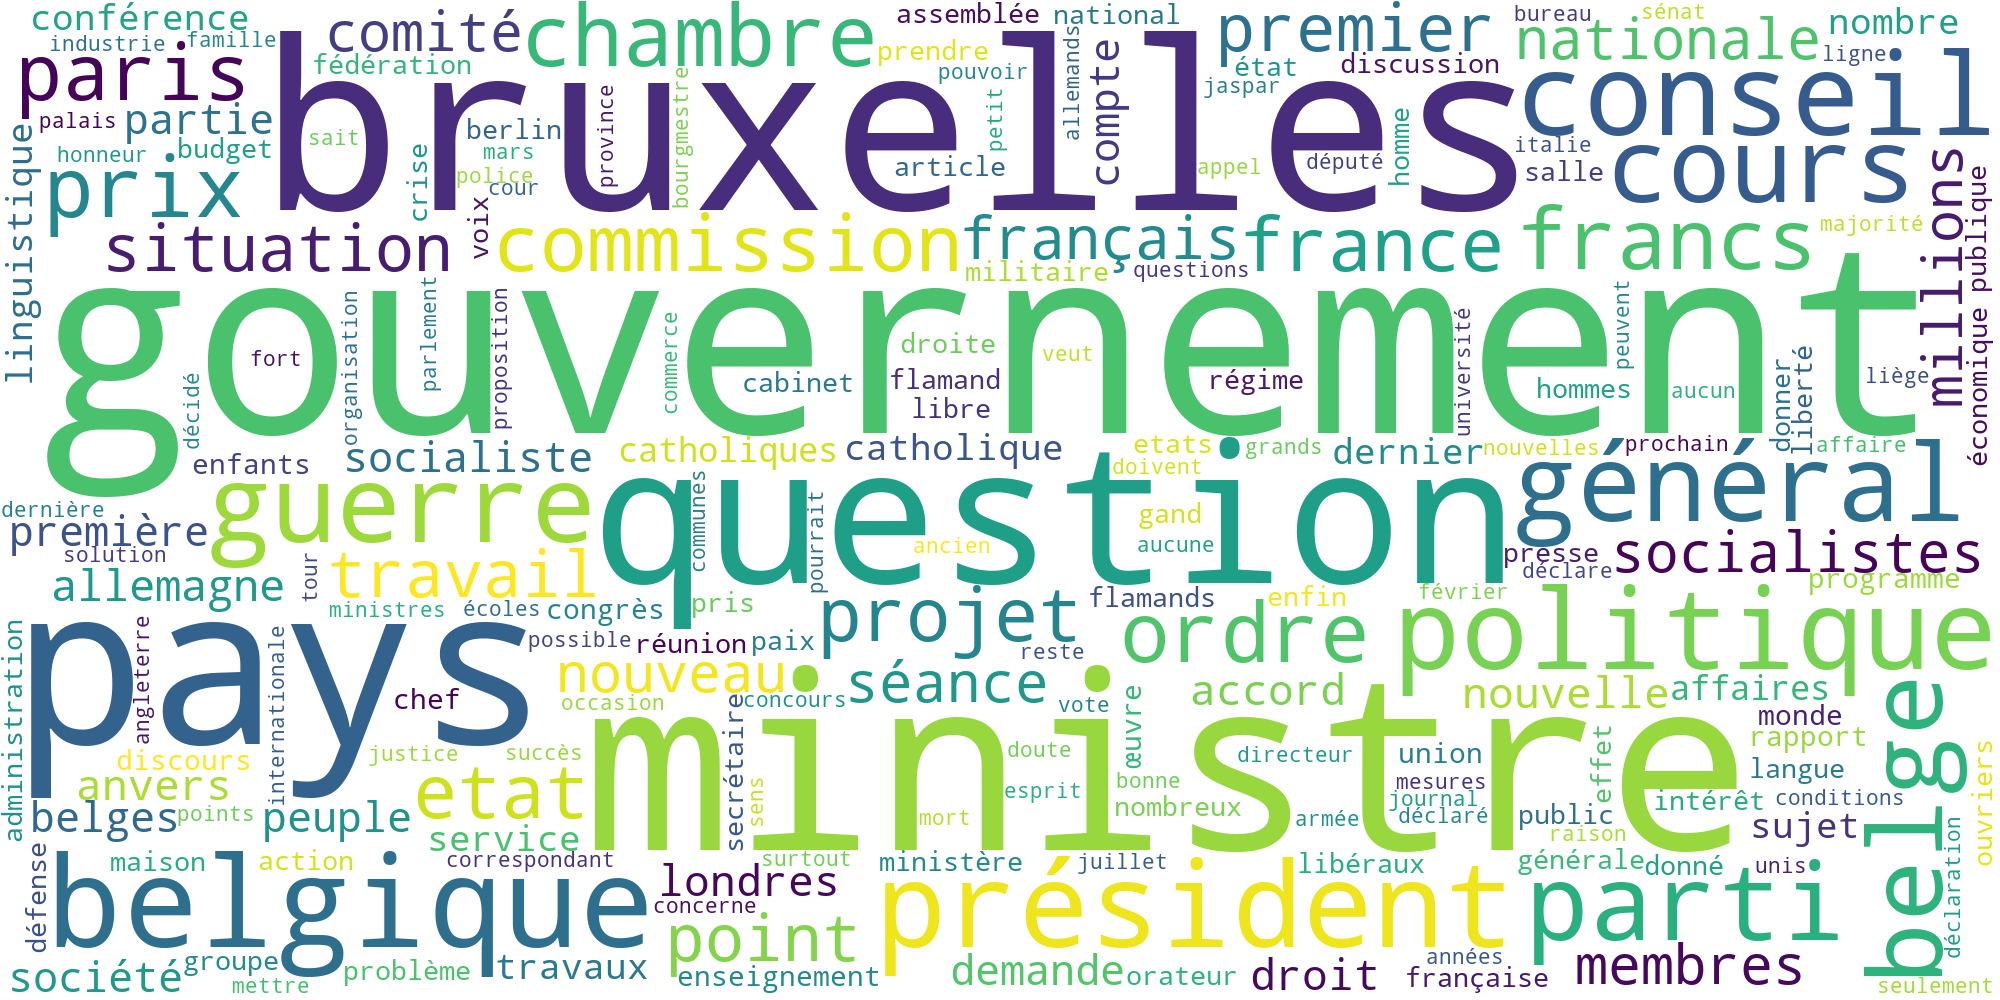

In [352]:
# Créer, stocker, afficher le nuage de mots

cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"tp4_all.png"))
Image(filename=os.path.join(temp_path, f"tp4_all.png"))

## Pour chaque journal

In [353]:
# Même procédure pour les fichiers de journaux

for i in nomJournaux:

    clean_text(i, folder=temp_path)

    with open(os.path.join(temp_path, f'clean_{i}'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print("Fréquences dans", i, ": ", frequencies.most_common(100))
    print("---")

    # Créer, stocker, afficher les nuages de mots

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"{i}.png"))
    Image(filename=os.path.join(temp_path, f"{i}.png"))

Fréquences dans tp4_LaLibreBelgique.txt :  [('gouvernement', 6419), ('ministre', 6132), ('question', 4943), ('pays', 4408), ('belgique', 4399), ('bruxelles', 4380), ('président', 3713), ('conseil', 3638), ('parti', 3444), ('politique', 3340), ('guerre', 3321), ('catholique', 3233), ('ordre', 3230), ('etat', 3110), ('général', 3051), ('belge', 2950), ('chambre', 2908), ('projet', 2874), ('cours', 2814), ('francs', 2800), ('point', 2691), ('commission', 2598), ('situation', 2576), ('premier', 2507), ('catholiques', 2488), ('correspondant', 2451), ('france', 2400), ('prix', 2398), ('socialistes', 2342), ('français', 2338), ('nationale', 2322), ('travail', 2268), ('millions', 2228), ('droit', 2154), ('nouveau', 2141), ('séance', 2092), ('membres', 2027), ('anvers', 1991), ('paris', 1987), ('compte', 1908), ('socialiste', 1903), ('enseignement', 1889), ('allemagne', 1860), ('demande', 1834), ('comité', 1828), ('flamand', 1826), ('nombre', 1814), ('nouvelle', 1800), ('droite', 1792), ('parti

# Reconnaissance d'entités nommées

In [148]:
# Charger le texte
n=100000
text_NER = open(os.path.join(temp_path, f"tp4_all.txt"), 'r', encoding="utf-8").read()[:n]

# Traiter le texte

doc = nlp(text_NER)

# Compter les entités (personnes, lieux, organisations)

people = defaultdict(int)
places = defaultdict(int)
orga = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        places[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        orga[ent.text] += 1

# Trier

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

In [149]:
# Imprimer les 10 premières personnes

for person, freq in sorted_people[:10]:
    print(f"{person} apparait {freq} fois dans le corpus")

Henry Bordeaux apparait 5 fois dans le corpus
président Wilson apparait 5 fois dans le corpus
Adler apparait 3 fois dans le corpus
M. von Kardorff apparait 3 fois dans le corpus
Lénine apparait 2 fois dans le corpus
Napoléon apparait 2 fois dans le corpus
Joseph apparait 2 fois dans le corpus
M. Io apparait 2 fois dans le corpus
M. Schiffer apparait 2 fois dans le corpus
M. Bordeaux apparait 2 fois dans le corpus


In [150]:
# Imprimer les 10 premiers lieux

for place, freq in sorted_places[:10]:
    print(f"{place} apparait {freq} fois dans le corpus")

Allemagne apparait 26 fois dans le corpus
Bruxelles apparait 16 fois dans le corpus
Belgique apparait 12 fois dans le corpus
Etat apparait 12 fois dans le corpus
Paris apparait 9 fois dans le corpus
Angleterre apparait 8 fois dans le corpus
Russie apparait 8 fois dans le corpus
Allemands apparait 7 fois dans le corpus
Versailles apparait 6 fois dans le corpus
Flamands apparait 6 fois dans le corpus


In [151]:
# Imprimer les 10 premières organisations

for orga, freq in sorted_orga[:10]:
    print(f"{orga} apparait {freq} fois dans le corpus")

Académie apparait 3 fois dans le corpus
Sénat apparait 2 fois dans le corpus
Chambre apparait 2 fois dans le corpus
fifdaelioH apparait 1 fois dans le corpus
miniM apparait 1 fois dans le corpus
Socialistes autrichiens apparait 1 fois dans le corpus
Dàntzie apparait 1 fois dans le corpus
Put- apparait 1 fois dans le corpus
Société des Nations apparait 1 fois dans le corpus
ministre d'Espagne apparait 1 fois dans le corpus


## Selon trois périodes temporelles

In [179]:
# Selon les 3 groupes d'années

nomAnnees = ["tp4_1919-1925.txt", "tp4_1929-1933.txt", "tp4_1935-1940.txt"]

for i in nomAnnees :

    # Charger le texte
    n=100000
    text_NER = open(os.path.join(temp_path, i), 'r', encoding="utf-8").read()[:n]

    # Traiter le texte

    doc = nlp(text_NER)

    # Compter les entités (personnes, lieux, organisations)

    people = defaultdict(int)
    places = defaultdict(int)
    orga = defaultdict(int)

    for ent in doc.ents:
        if ent.label_ == "PER" and len(ent.text) > 3:
            people[ent.text] += 1
        elif ent.label_ == "LOC" and len(ent.text) > 3:
            places[ent.text] += 1
        elif ent.label_ == "ORG" and len(ent.text) > 3:
            orga[ent.text] += 1

    # Trier

    sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
    sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
    sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

    # Imprimer

    print(i)
    print("Personnes :")
    for person, freq in sorted_people[:10]:
        print(f"{person} apparait {freq} fois dans le corpus")
    
    print("Lieux :")
    for place, freq in sorted_places[:10]:
        print(f"{place} apparait {freq} fois dans le corpus")

    print("Organisations :")
    for orga, freq in sorted_orga[:10]:
        print(f"{orga} apparait {freq} fois dans le corpus")
    
    print("---")

tp4_1919-1925.txt
Personnes :
Henry Bordeaux apparait 5 fois dans le corpus
président Wilson apparait 5 fois dans le corpus
Adler apparait 3 fois dans le corpus
M. von Kardorff apparait 3 fois dans le corpus
Lénine apparait 2 fois dans le corpus
Napoléon apparait 2 fois dans le corpus
Joseph apparait 2 fois dans le corpus
M. Io apparait 2 fois dans le corpus
M. Schiffer apparait 2 fois dans le corpus
M. Bordeaux apparait 2 fois dans le corpus
Lieux :
Allemagne apparait 26 fois dans le corpus
Bruxelles apparait 16 fois dans le corpus
Belgique apparait 12 fois dans le corpus
Etat apparait 12 fois dans le corpus
Paris apparait 9 fois dans le corpus
Angleterre apparait 8 fois dans le corpus
Russie apparait 8 fois dans le corpus
Allemands apparait 7 fois dans le corpus
Versailles apparait 6 fois dans le corpus
Flamands apparait 6 fois dans le corpus
Organisations :
Académie apparait 3 fois dans le corpus
Sénat apparait 2 fois dans le corpus
Chambre apparait 2 fois dans le corpus
fifdaelioH 

## Selon les journaux

In [180]:
# Selon les 3 journaux

for i in nomJournaux :

    # Charger le texte
    n=100000
    text_NER = open(os.path.join(temp_path, i), 'r', encoding="utf-8").read()[:n]

    # Traiter le texte

    doc = nlp(text_NER)

    # Compter les entités (personnes, lieux, organisations)

    people = defaultdict(int)
    places = defaultdict(int)
    orga = defaultdict(int)

    for ent in doc.ents:
        if ent.label_ == "PER" and len(ent.text) > 3:
            people[ent.text] += 1
        elif ent.label_ == "LOC" and len(ent.text) > 3:
            places[ent.text] += 1
        elif ent.label_ == "ORG" and len(ent.text) > 3:
            orga[ent.text] += 1

    # Trier

    sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
    sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
    sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

    # Imprimer

    print(i)
    print("Personnes :")
    for person, freq in sorted_people[:10]:
        print(f"{person} apparait {freq} fois dans le corpus")
    
    print("Lieux :")
    for place, freq in sorted_places[:10]:
        print(f"{place} apparait {freq} fois dans le corpus")

    print("Organisations :")
    for orga, freq in sorted_orga[:10]:
        print(f"{orga} apparait {freq} fois dans le corpus")
    
    print("---")

tp4_LaLibreBelgique.txt
Personnes :
Henry Bordeaux apparait 5 fois dans le corpus
président Wilson apparait 5 fois dans le corpus
Adler apparait 3 fois dans le corpus
M. von Kardorff apparait 3 fois dans le corpus
Lénine apparait 2 fois dans le corpus
Napoléon apparait 2 fois dans le corpus
Joseph apparait 2 fois dans le corpus
M. Io apparait 2 fois dans le corpus
M. Schiffer apparait 2 fois dans le corpus
M. Bordeaux apparait 2 fois dans le corpus
Lieux :
Allemagne apparait 26 fois dans le corpus
Bruxelles apparait 16 fois dans le corpus
Belgique apparait 12 fois dans le corpus
Etat apparait 12 fois dans le corpus
Paris apparait 9 fois dans le corpus
Angleterre apparait 8 fois dans le corpus
Russie apparait 8 fois dans le corpus
Allemands apparait 7 fois dans le corpus
Versailles apparait 6 fois dans le corpus
Flamands apparait 6 fois dans le corpus
Organisations :
Académie apparait 3 fois dans le corpus
Sénat apparait 2 fois dans le corpus
Chambre apparait 2 fois dans le corpus
fifda

# Clustering

In [153]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

### Clustering sur le corpus complet

#### Faire les clusters

In [154]:
files = [f for f in sorted(os.listdir(path))]

texts = [open(path + f, "r", encoding="utf-8").read() for f in files]

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

# Imprimer les détails de la matrice

tfidf_vectors

<2035x4015 sparse matrix of type '<class 'numpy.float64'>'
	with 1702752 stored elements in Compressed Sparse Row format>

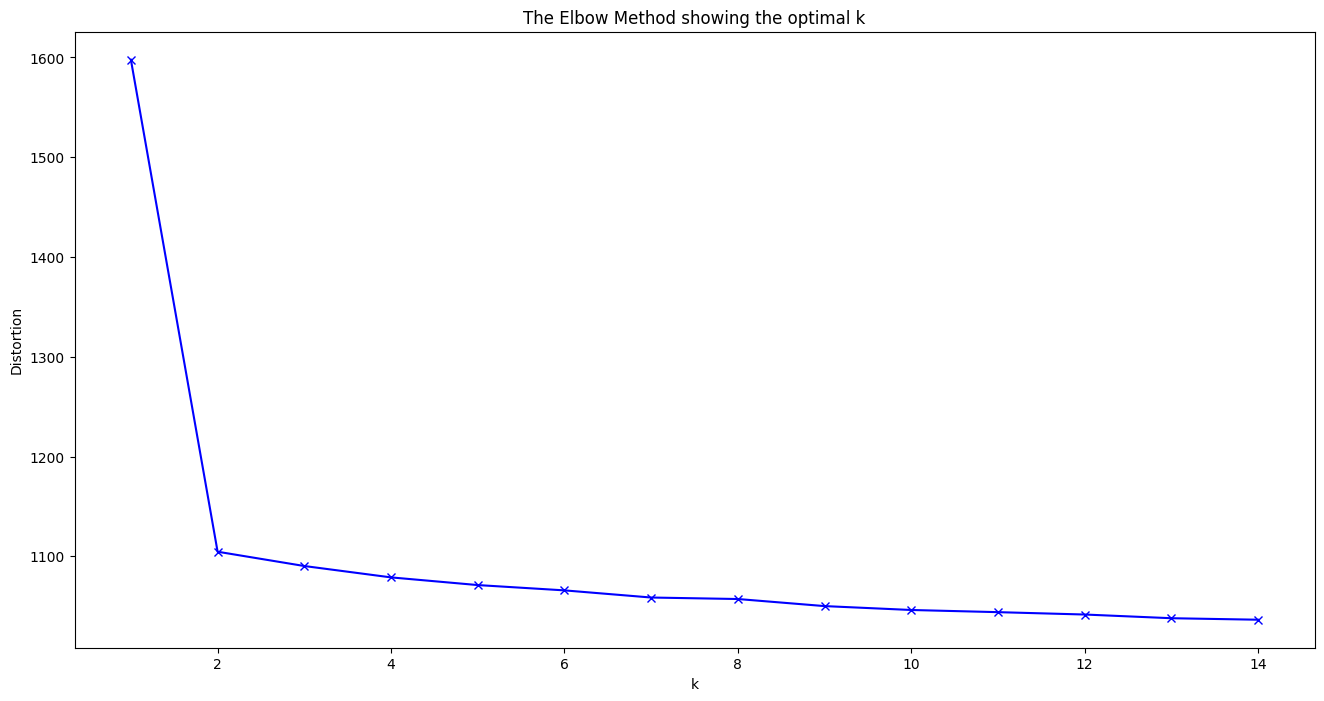

In [155]:
# Elbow method pour déterminer le nbre de clusters optimal

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [156]:
# Nbre clusters

N_CLUSTERS = 2

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [157]:
# Afficher le résultat du clustering (un dictionnaire)

dict(clustering)[1]

['KB_JB427_1919-03-31_01-00001.txt',
 'KB_JB427_1919-05-31_01-00001.txt',
 'KB_JB427_1919-06-19_01-00002.txt',
 'KB_JB427_1919-08-08_01-00002.txt',
 'KB_JB427_1919-08-20_01-00002.txt',
 'KB_JB427_1919-09-07_01-00001.txt',
 'KB_JB427_1919-09-08_01-00002.txt',
 'KB_JB427_1919-09-09_01-00002.txt',
 'KB_JB427_1919-09-11_01-00003.txt',
 'KB_JB427_1919-09-24_01-00002.txt',
 'KB_JB427_1919-09-27_01-00002.txt',
 'KB_JB427_1919-10-13_01-00001.txt',
 'KB_JB427_1919-10-14_01-00002.txt',
 'KB_JB427_1919-10-19_01-00002.txt',
 'KB_JB427_1919-10-29_01-00002.txt',
 'KB_JB427_1919-11-02_01-00002.txt',
 'KB_JB427_1919-12-03_01-00002.txt',
 'KB_JB427_1920-03-03_01-00002.txt',
 'KB_JB427_1920-03-03_01-00003.txt',
 'KB_JB427_1920-03-10_01-00002.txt',
 'KB_JB427_1920-03-10_01-00003.txt',
 'KB_JB427_1920-03-20_01-00002.txt',
 'KB_JB427_1920-03-26_01-00004.txt',
 'KB_JB427_1920-04-17_01-00001.txt',
 'KB_JB427_1920-05-07_01-00003.txt',
 'KB_JB427_1920-05-15_01-00003.txt',
 'KB_JB427_1920-05-31_01-00002.txt',
 

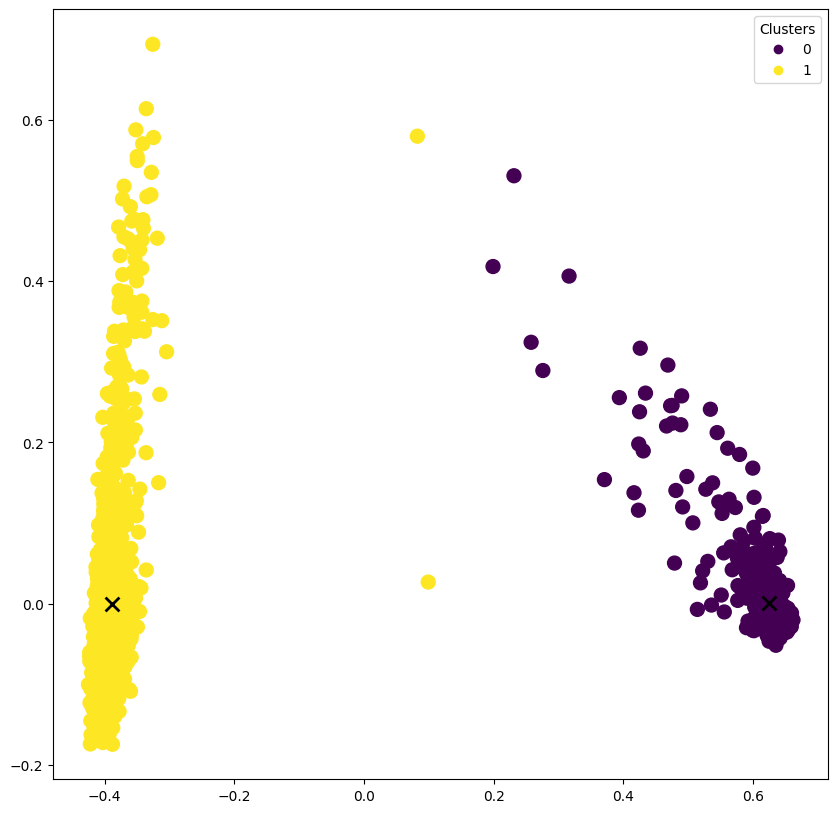

In [158]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

### Explorer les clusters

In [159]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

In [160]:
# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

Nombre de documents dans le cluster 1 : 1255
Nombre de documents dans le cluster 0 : 780


Cluster n° 1, Nbre doc : 1255, Counter({'1929': 150, '1930': 150, '1931': 130, '1932': 103, '1938': 65, '1920': 60, '1937': 60, '1923': 55, '1939': 53, '1936': 51, '1921': 49, '1922': 43, '1935': 29, '1924': 28, '1927': 26, '1928': 26, '1925': 24, '1919': 23, '1933': 22, '1940': 21, '1934': 19, '1926': 17, '1948': 12, '1949': 12, '1947': 10, '1950': 6, '1945': 5, '1946': 5, '1944': 1})


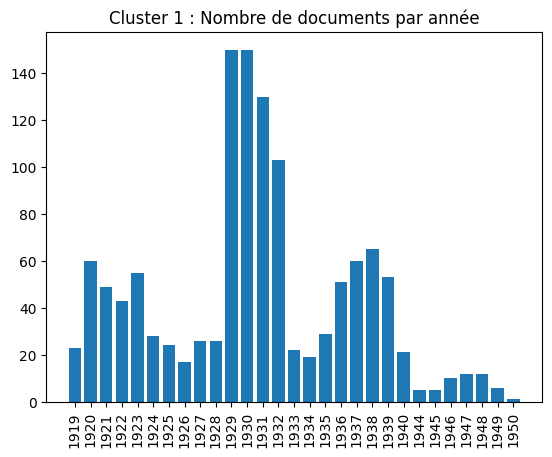

Cluster n° 0, Nbre doc : 780, Counter({'1930': 115, '1929': 94, '1931': 81, '1932': 79, '1937': 43, '1936': 41, '1939': 36, '1938': 35, '1921': 30, '1923': 26, '1935': 24, '1920': 21, '1933': 20, '1922': 18, '1940': 15, '1925': 12, '1927': 10, '1928': 9, '1949': 9, '1924': 8, '1934': 8, '1919': 7, '1926': 5, '1947': 5, '1948': 5, '1941': 4, '1943': 4, '1946': 4, '1950': 4, '1944': 3, '1945': 3, '1942': 2})


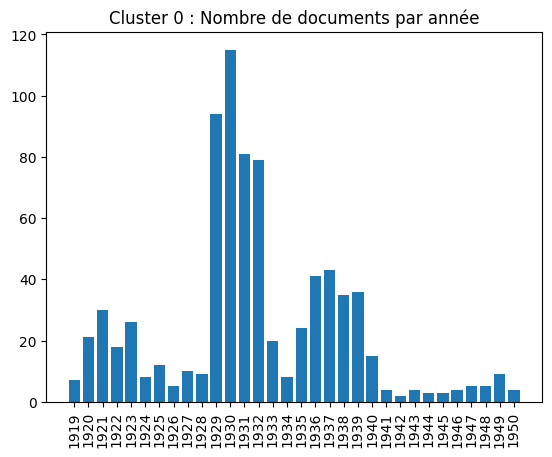

In [161]:
# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()


In [162]:
# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

Bigrammes récurrents, cluster n° 1 : ['Libre Belgique', 'VAN CAUWELAERT', 'parti catholique', 'van Zeeland', 'gouvernement belge', 'parti socialiste', 'peuple flamand', 'Conseil général', 'Société Nationale', 'nation belge', 'question linguistique', 'défense nationale']
Trigrammes récurrents, cluster n° 1 : ['Parti ouvrier belge', 'gouvernement van Zeeland', 'jour LIBRE BELGIQUE', 'Anvers Bruxelles Gand', 'LIBRE BELGIQUE ANNONCES', 'GRAND BRUXELLES Bruxelles', 'parti socialiste belge', 'OUVRIER BELGE BRUXELLES', 'Bruxelles CHAMBRE Catholiques', 'Bloc catholique belge', 'parti catholique belge', 'ministres catholiques flamands', 'Bruxelles dimanche matin', 'parti socialiste français', 'Bruxelles Gand Charleroi', 'cardinal Van Roey', 'Paul van Zeeland', "cours d'une réunion", "constitution d'une commission", 'jeunesse catholique belge', "l'Union catholique belge", "cours d'une conférence", "Bruxelles C'est jeudi", "Bruxelles d'une Maison", 'Bruxelles Jeudi Londres', 'Angleterre France Be

Cluster n° 1, Nbre doc : 1255, Counter({'JB427': 700, 'JB837': 553, 'JB838': 2})


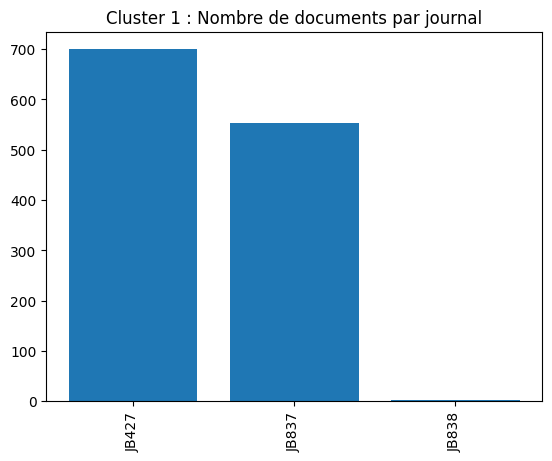

Cluster n° 0, Nbre doc : 780, Counter({'JB838': 780})


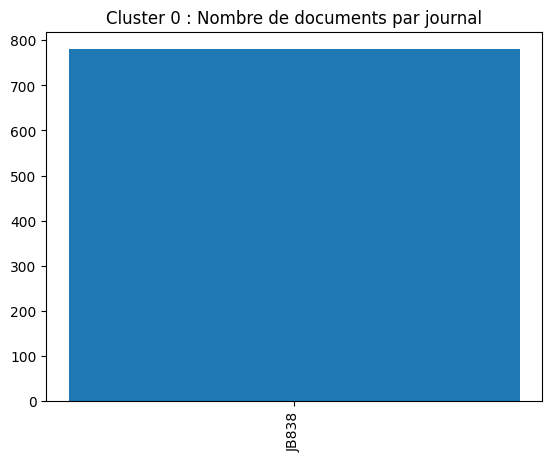

In [163]:
# Regarder la distribution des clusters selon les journaux

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_newspaper(filename):
    year = (re.search("(JB[0-9]{3})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
np_per_cluster = []
for key in clustering.keys():
    np_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        np_per_cluster[key].append(get_newspaper(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(np_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par journal")
    plt.show()

### Clustering journal par journal

#### Faire les clusters

In [223]:
# Journal par journal
# Semble demander des listes de fichiers et pas un fichier global? -> retour à la liste de fichiers et au tri via code du journal

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

LaLibreBelgique_list = []
LePeuple_list = []
LeSoir_list = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):
        elems = txt.split("_")
        newspaper = elems[1]    
    
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if newspaper == "JB427": # La Libre
                LaLibreBelgique_list.append(f.read())

            if newspaper == "JB837": # Le Peuple
                LePeuple_list.append(f.read())

            if newspaper == "JB838": # Le Soir
                LeSoir_list.append(f.read())
    
    else:
        print(f"Anomalous file: {f}")

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors_LLB = vectorizer.fit_transform(LaLibreBelgique_list)
tfidf_vectors_LP = vectorizer.fit_transform(LePeuple_list)
tfidf_vectors_LS = vectorizer.fit_transform(LeSoir_list)

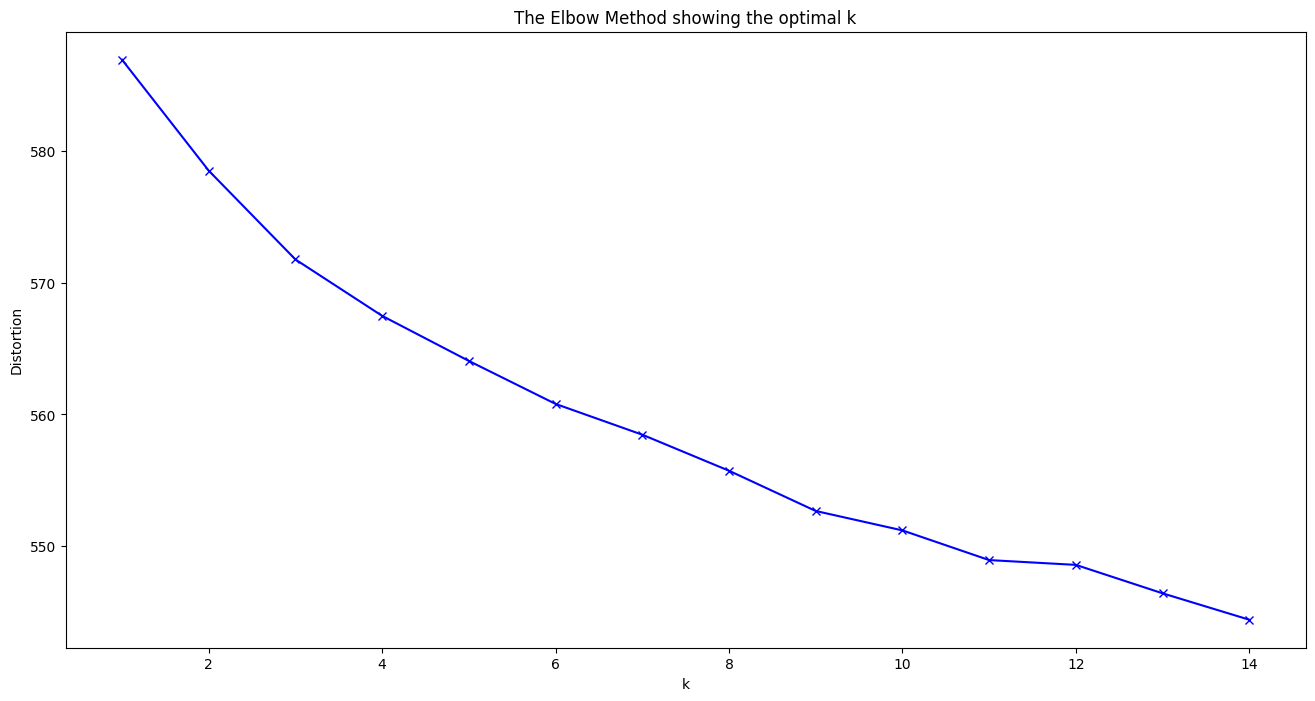

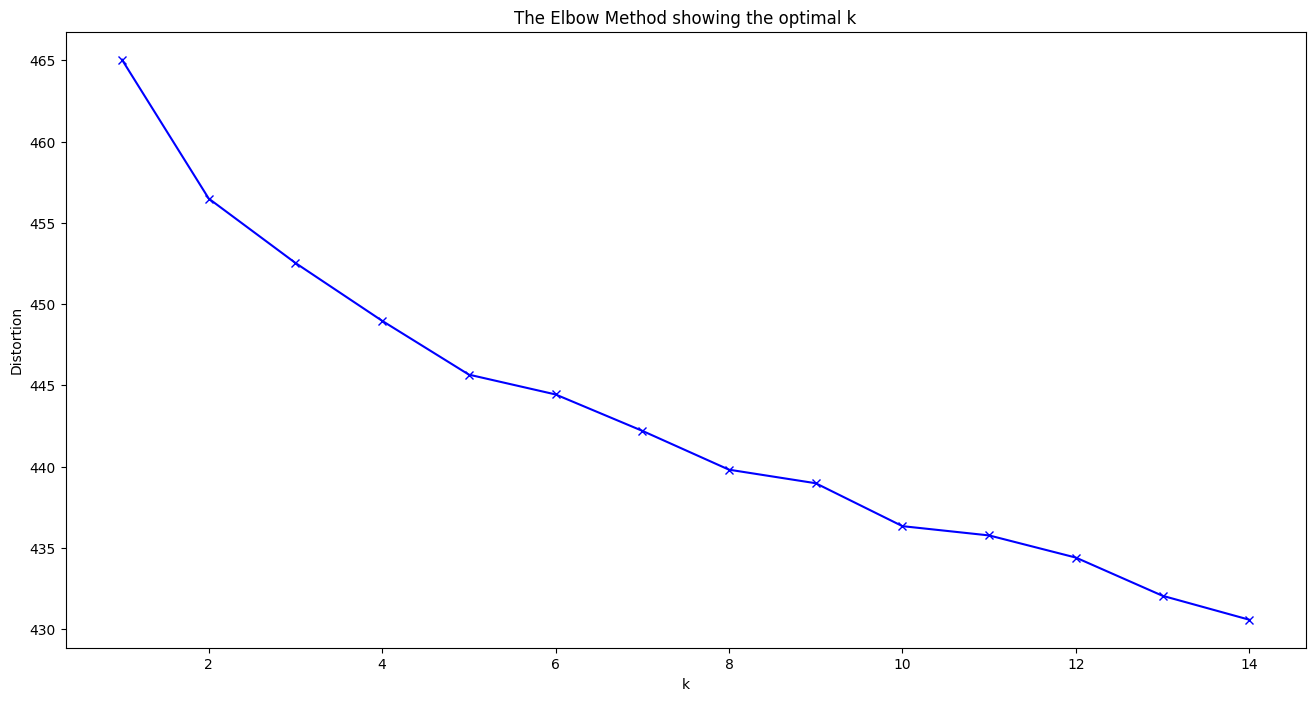

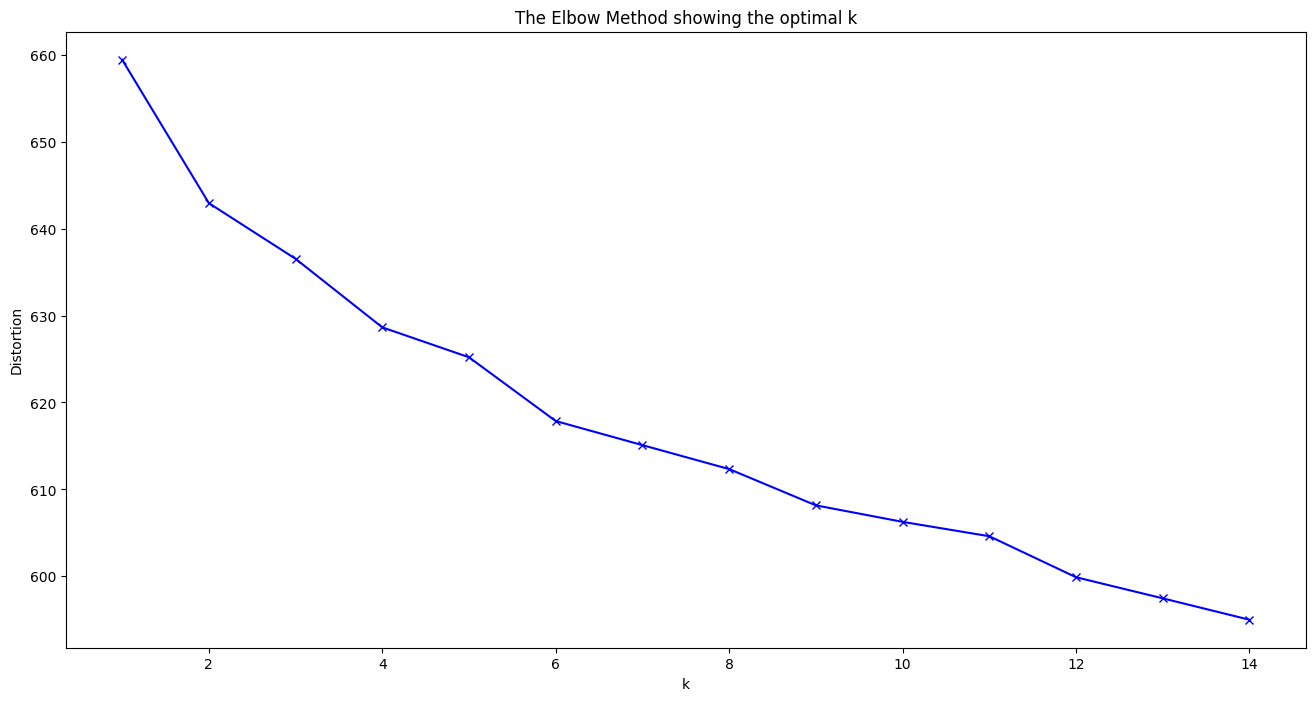

In [185]:
tfidf_vectors_list = [tfidf_vectors_LLB, tfidf_vectors_LP, tfidf_vectors_LS]

# Elbow method pour déterminer le nbre de clusters optimal

for i in len(tfidf_vectors_list):

    distortions = []
    K = range(1,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(tfidf_vectors_list[i])
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'The Elbow Method showing the optimal k for {i}')
    plt.show()

#### Cluster de La Libre Belgique

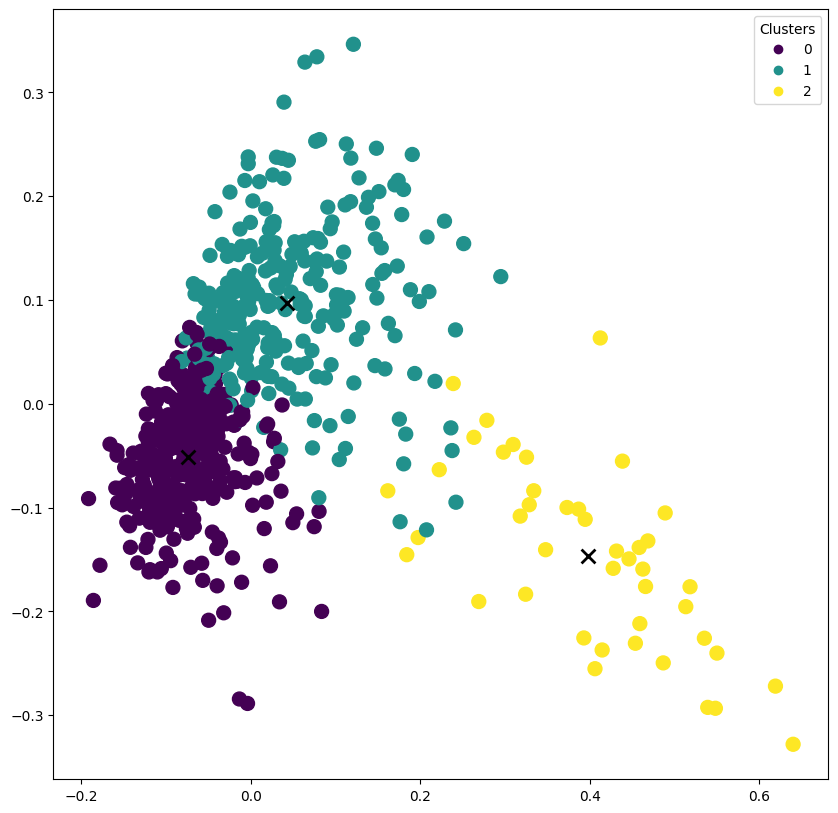

Nombre de documents dans le cluster 1 : 270
Nombre de documents dans le cluster 0 : 387
Nombre de documents dans le cluster 2 : 43
Cluster n° 1, Nbre doc : 270, Counter({'1929': 38, '1930': 35, '1931': 24, '1920': 20, '1921': 17, '1932': 16, '1919': 15, '1922': 11, '1923': 10, '1924': 10, '1937': 10, '1938': 8, '1939': 8, '1928': 7, '1927': 6, '1933': 6, '1947': 5, '1925': 4, '1926': 4, '1936': 4, '1935': 3, '1940': 3, '1948': 3, '1945': 1, '1946': 1, '1950': 1})


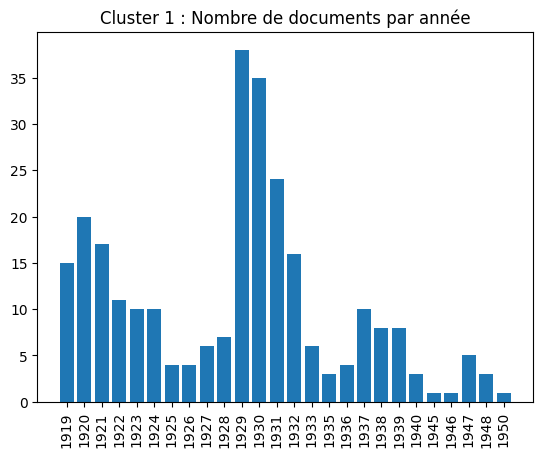

Cluster n° 0, Nbre doc : 387, Counter({'1931': 45, '1929': 44, '1930': 40, '1932': 30, '1936': 22, '1938': 19, '1922': 18, '1939': 17, '1923': 16, '1921': 14, '1935': 14, '1937': 14, '1920': 13, '1925': 12, '1940': 12, '1924': 11, '1927': 8, '1928': 8, '1949': 7, '1934': 6, '1926': 4, '1948': 4, '1950': 4, '1919': 2, '1947': 2, '1933': 1})


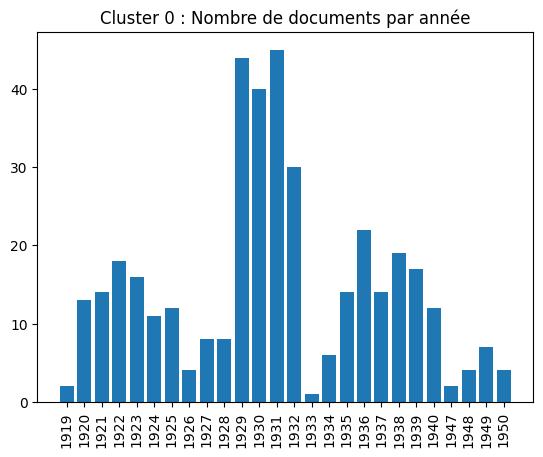

Cluster n° 2, Nbre doc : 43, Counter({'1932': 7, '1920': 5, '1933': 5, '1938': 5, '1921': 3, '1931': 3, '1936': 3, '1930': 2, '1935': 2, '1939': 2, '1922': 1, '1923': 1, '1926': 1, '1929': 1, '1934': 1, '1945': 1})


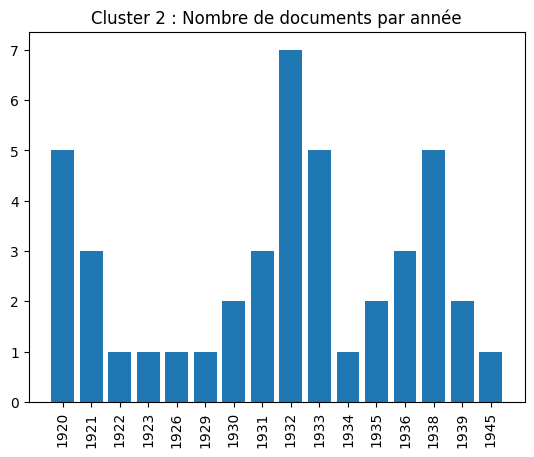

In [240]:
# Nbre clusters

N_CLUSTERS = 3

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors_LLB)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors_LLB.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")
plt.show()

# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_LLB_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

In [230]:
# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_LLB_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

# Mots les plus fréquents

# Stopwords
sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi", 
    # Coquilles + mots sans sémantiques discrimantes d'après les mots les plus fréquents
    "heures", "grand", "jour", "lieu", "temps", "grande", "part", "mois", "matin", "soir", "aujourd", "moment", "jours", "fois", "heure", "jamais", "également", "ailleurs", "hier", "vient", "année", "certains", "cependant", "parce"
    ]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"tp4_LLB_cluster_{key}.txt"
        output_path = f"tp4_LLB_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}tp4_LLB_cluster_{key}.txt"
        output_path = f"{folder}tp4_LLB_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

# Appliquer la fonction et vérifier les résultats

for key in clustering.keys():

    clean_text(key, folder=temp_path)

    with open(os.path.join(temp_path, f'tp4_LLB_cluster_{key}_clean.txt'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print(f"Cluster n° {key} :", frequencies.most_common(200))
    print("")

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"tp4_LLB_cluster_{key}.png"))

Bigrammes récurrents, cluster n° 2 : ['Libre Belgique', 'VAN CAUWELAERT', 'conseil communal', 'gouvernement belge', "cours d'une", 'Van den', 'question linguistique', 'cardinal Van', 'Mgr Van', 'parti catholique', 'fédération nationale', 'Mme Van', 'Société Nationale', 'dimanche matin', 'roi Albert', "d'autre part"]
Trigrammes récurrents, cluster n° 2 : ['cardinal Van Roey', 'BRUXELLES Dimanche matin', 'Mgr Van Roey', "cours d'une réunion", 'président Van COURS', 'BRUXELLES Mercredi matin', "d'un gouvernement belge", "conseil communal s'est", "cours d'une conférence", "cours d'une séance", 'Mme Marie Van', "d'un grand nombre", "conseil s'est réuni", 'ROI ALBERT Paris']

Bigrammes récurrents, cluster n° 0 : ['Libre Belgique', 'Van Cauwelaert', "Mais c'est", 'parti catholique', 'van Zeeland', 'gouvernement belge', 'défense nationale', 'catholique belge', 'question linguistique', "mais qu'il", 'Banque Nationale', 'Société nationale', "qu'il faut", 'parti socialiste', 'catholiques flamands

#### Cluster du Peuple

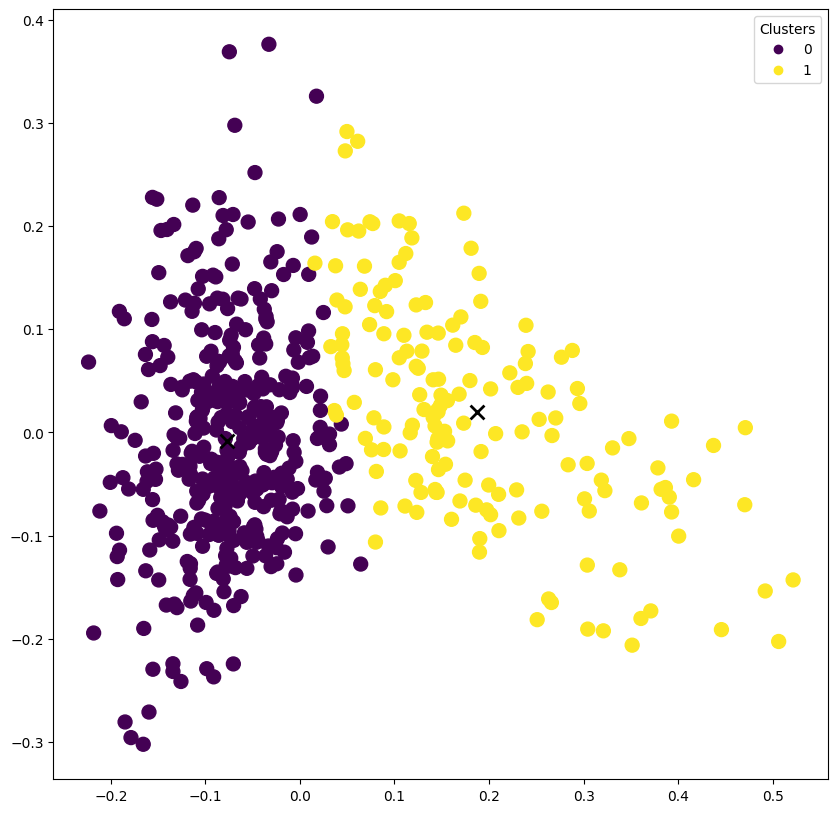

Nombre de documents dans le cluster 0 : 392
Nombre de documents dans le cluster 1 : 161
Cluster n° 0, Nbre doc : 392, Counter({'1929': 54, '1931': 51, '1930': 43, '1932': 40, '1921': 32, '1920': 28, '1922': 22, '1923': 18, '1919': 16, '1935': 16, '1924': 15, '1925': 11, '1933': 10, '1926': 9, '1927': 9, '1928': 9, '1936': 6, '1934': 3})


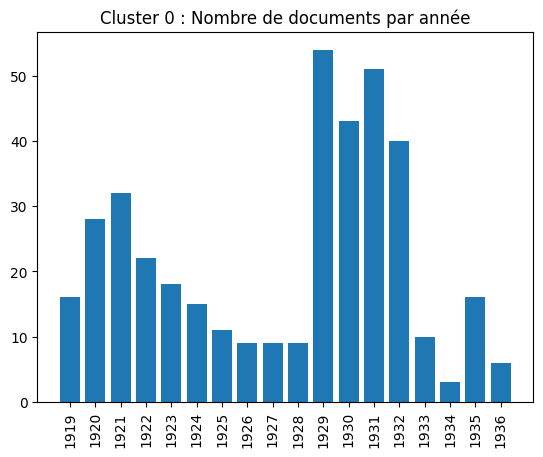

Cluster n° 1, Nbre doc : 161, Counter({'1930': 34, '1929': 29, '1931': 21, '1932': 13, '1920': 10, '1923': 9, '1922': 8, '1924': 6, '1928': 6, '1925': 5, '1927': 5, '1934': 4, '1935': 3, '1936': 3, '1921': 2, '1933': 2, '1919': 1})


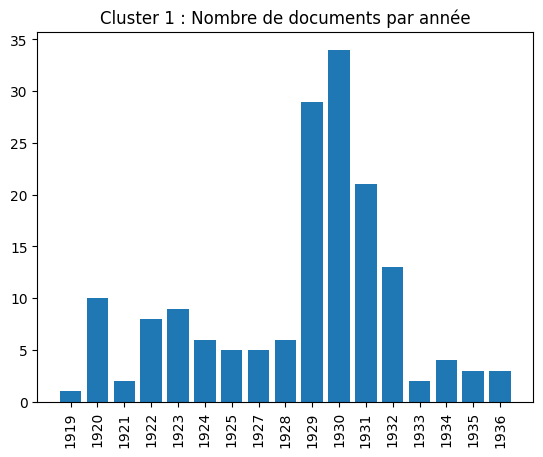

In [249]:
# Nbre clusters

N_CLUSTERS = 2

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors_LP)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors_LP.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")
plt.show()

# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_LP_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

In [250]:
# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_LP_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

# Mots les plus fréquents

# Stopwords
sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi", 
    # Coquilles + mots sans sémantiques discrimantes d'après les mots les plus fréquents
    "heures", "grand", "jour", "lieu", "temps", "grande", "part", "mois", "matin", "soir", "aujourd", "moment", "jours", "fois", "heure", "jamais", "également", "ailleurs", "hier", "vient", "année", "certains", "cependant", "parce"
    ]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"tp4_LP_cluster_{key}.txt"
        output_path = f"tp4_LP_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}tp4_LP_cluster_{key}.txt"
        output_path = f"{folder}tp4_LP_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

# Appliquer la fonction et vérifier les résultats

for key in clustering.keys():

    clean_text(key, folder=temp_path)

    with open(os.path.join(temp_path, f'tp4_LP_cluster_{key}_clean.txt'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print(f"Cluster n° {key} :", frequencies.most_common(200))
    print("")

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"tp4_LP_cluster_{key}.png"))

Bigrammes récurrents, cluster n° 0 : ['Libre Belgique', 'VAN CAUWELAERT', 'question linguistique', 'gouvernement belge', 'van den', 'parti catholique', 'Société Nationale', 'catholique belge', 'défense nationale', 'conseil communal', "qu'il faut", 'pays flamand', 'Mgr Van', 'gouvernement allemand', 'gouvernement français', "cours d'une"]
Trigrammes récurrents, cluster n° 0 : ['LIBRE BELGIQUE ANNONCES', 'Bruxelles CHAMBRE Catholiques', "l'Union catholique belge", 'jour LIBRE BELGIQUE', 'cardinal Van Roey', 'ministres catholiques flamands', 'Mlle Van den', 'jeunesse catholique belge', 'Roi Albert Bruxelles', 'Bruxelles dimanche matin', "cours d'une réunion", 'Van Cauwelaert dit', 'Mgr Van Roey', "c'est parce qu'ils", 'LIBRE BELGIQUE REVUE', 'parti catholique belge', 'ministre Van Isacker', "cours d'une séance", "d'un grand nombre"]

Bigrammes récurrents, cluster n° 1 : ['LIBRE BELGIQUE', 'Van Cauwelaert', 'question linguistique', 'parti catholique', 'gouvernement belge', 'VAN DEN', "cour

#### Cluster du Soir

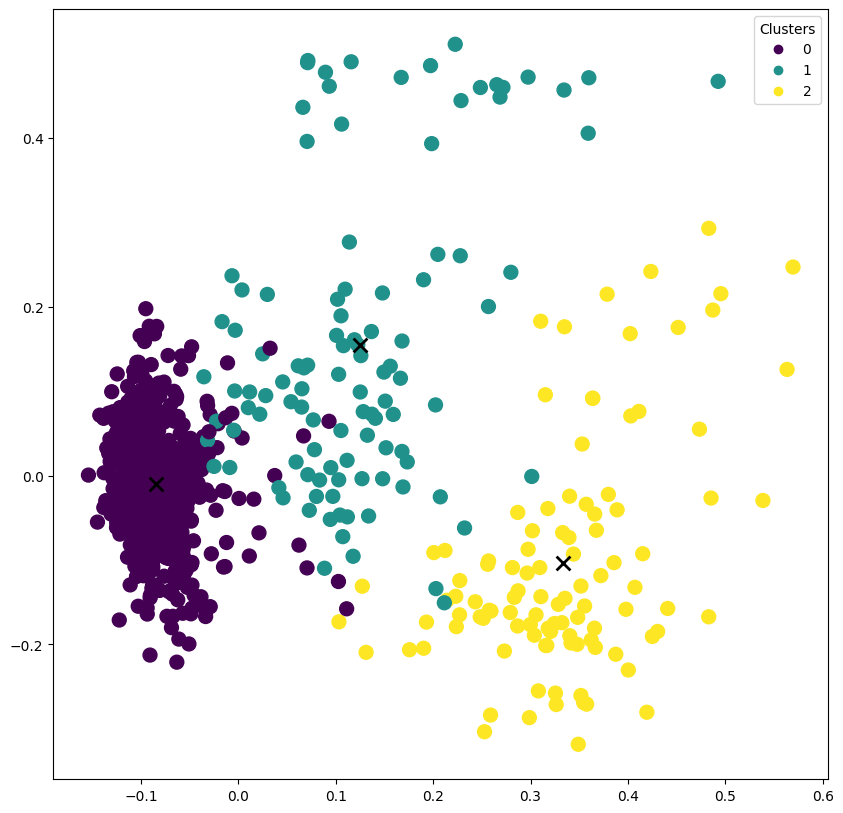

In [236]:
# Nbre clusters

N_CLUSTERS = 3

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors_LS)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors_LS.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")
plt.show()

Nombre de documents dans le cluster 0 : 572
Nombre de documents dans le cluster 1 : 109
Nombre de documents dans le cluster 2 : 101
Cluster n° 0, Nbre doc : 572, Counter({'1929': 55, '1920': 50, '1930': 48, '1921': 46, '1931': 46, '1923': 39, '1922': 35, '1932': 33, '1936': 24, '1938': 24, '1939': 20, '1924': 19, '1937': 19, '1919': 18, '1925': 15, '1935': 13, '1927': 11, '1933': 11, '1928': 8, '1940': 8, '1926': 7, '1947': 5, '1948': 5, '1949': 5, '1934': 3, '1945': 2, '1950': 2, '1946': 1})


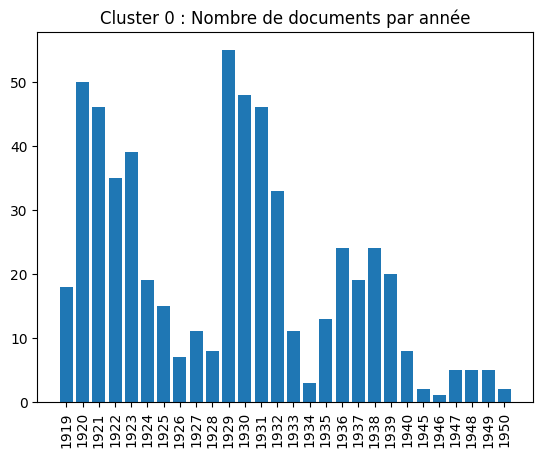

Cluster n° 1, Nbre doc : 109, Counter({'1929': 13, '1930': 12, '1923': 9, '1920': 8, '1928': 7, '1931': 7, '1940': 6, '1922': 5, '1938': 5, '1939': 4, '1919': 3, '1921': 3, '1927': 3, '1935': 3, '1936': 3, '1924': 2, '1926': 2, '1932': 2, '1937': 2, '1948': 2, '1949': 2, '1950': 2, '1925': 1, '1933': 1, '1934': 1, '1947': 1})


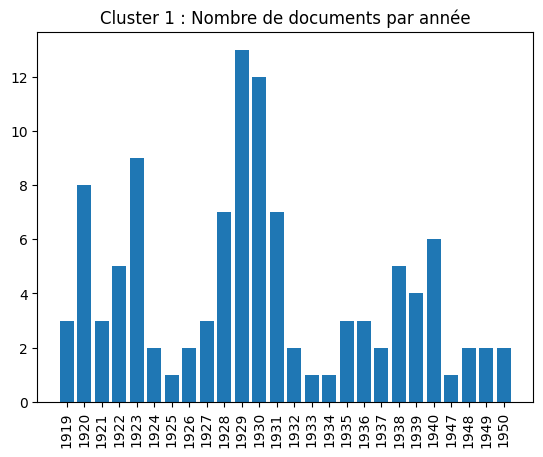

Cluster n° 2, Nbre doc : 101, Counter({'1931': 19, '1932': 18, '1930': 17, '1929': 15, '1923': 5, '1922': 3, '1934': 3, '1935': 3, '1937': 3, '1938': 3, '1939': 3, '1936': 2, '1919': 2, '1920': 2, '1940': 1, '1947': 1, '1950': 1})


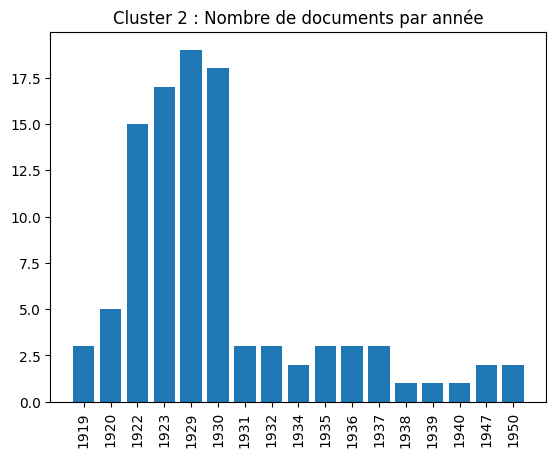

Bigrammes récurrents, cluster n° 0 : ['Libre Belgique', 'VAN CAUWELAERT', 'parti catholique', 'gouvernement belge', 'van Zeeland', 'question linguistique', 'van den', 'défense nationale', 'catholique belge', 'Société Nationale', 'parti socialiste', 'conseil communal', 'gouvernement allemand', 'Conseil général', 'fédération nationale', 'peuple flamand', "qu'il faut"]
Trigrammes récurrents, cluster n° 0 : ['jour LIBRE BELGIQUE', 'LIBRE BELGIQUE ANNONCES', 'Bruxelles CHAMBRE Catholiques', 'Bloc catholique belge', 'gouvernement van Zeeland', "l'Union catholique belge", 'parti catholique belge', 'cardinal Van Roey', 'parti socialiste belge', 'jeunesse catholique belge', 'Parti ouvrier belge', 'Bruxelles dimanche matin', "cours d'une réunion", 'Angleterre France Belgique', 'Belgique Comité Catholique', 'Van Cauwelaert dit', 'LIBRE BELGIQUE ABONNEMENTS', "c'est parce qu'il", 'Mgr Van Roey', 'ministres catholiques flamands', 'parti catholique flamand', "cours d'un conseil", 'ministre Van Isack

In [232]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_LS_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_LS_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

# Mots les plus fréquents

# Stopwords
sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi", 
    # Coquilles + mots sans sémantiques discrimantes d'après les mots les plus fréquents
    "heures", "grand", "jour", "lieu", "temps", "grande", "part", "mois", "matin", "soir", "aujourd", "moment", "jours", "fois", "heure", "jamais", "également", "ailleurs", "hier", "vient", "année", "certains", "cependant", "parce"
    ]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"tp4_LS_cluster_{key}.txt"
        output_path = f"tp4_LS_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}tp4_LS_cluster_{key}.txt"
        output_path = f"{folder}tp4_LS_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

# Appliquer la fonction et vérifier les résultats

for key in clustering.keys():

    clean_text(key, folder=temp_path)

    with open(os.path.join(temp_path, f'tp4_LS_cluster_{key}_clean.txt'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print(f"Cluster n° {key} :", frequencies.most_common(200))
    print("")

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"tp4_LS_cluster_{key}.png"))

# Word Embeddings

In [82]:
# Sentence tokenizer

def sentence_tokenizer(inFile, outFile, LIMIT=None):

    with open(outFile, 'w', encoding="utf-8") as output:
        with open(inFile, encoding="utf-8", errors="backslashreplace") as f:
            content = f.readlines()
            content = content[:LIMIT] if LIMIT is not None else content
            n_lines = len(content)
            for i, line in enumerate(content):
                if i % 100 == 0:
                    print(f'processing line {i}/{n_lines}')
                sentences = sent_tokenize(line)
                for sent in sentences:
                    output.write(sent + "\n")
    print("Done")

In [84]:
# Créer un fichier par journal (pas de fichier global)

for i in nomJournaux:
    inFile = f"{temp_path}{i}"
    outFile = f"{temp_path}sents_{i}"

    sentence_tokenizer(inFile, outFile)
    print("Done", i)

processing line 0/1
Done
Done tp4_LaLibreBelgique.txt
processing line 0/1
Done
Done tp4_LePeuple.txt
processing line 0/1
Done
Done tp4_LeSoir.txt


## Création des modèles

In [167]:
# Création d'un objet qui streame les lignes d'un fichier pour économiser de la RAM

class MySentences(object):
    """Tokenize and Lemmatize sentences""" # Permet de tokenizer des "doubles" mots, par ex "premier" + "ministre" va être considéré comme un token "premier ministre"
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]


for i in nomJournaux:
    infile = f"{temp_path}sents_{i}"
    sentences = MySentences(infile)
    print("Done MySentences", i)

    # Création de l'objet 'phrases' = "dictionnaire d'expressions multi-mots associées à un score", dont les clés correspondent aux termes du corpus

    bigram_phrases = Phrases(sentences)

    # Conversion des objets 'phrases' en objet 'phraser' = version light du 'phrases' -> convertit certains unigrams en bigrams s'ils sont pertinents

    bigram_phraser = Phraser(phrases_model=bigram_phrases)

    print("Done bigrams", i)

    # Ouvrir l'objet Phraser des bigrammes

    trigram_phrases = Phrases(bigram_phraser[sentences])

    # Conversion en objet Phraser et sauvegarde du Phraser des trigrammes

    trigram_phraser = Phraser(phrases_model=trigram_phrases)

    print("Done trigrams", i)

    # Création du corpus

    corpus = list(trigram_phraser[bigram_phraser[sentences]])

    # Imprimer une liste de n-grammes, qu'on répère car ils sont séparés par des _
    
    print("")
    print(i)
    print(corpus[:5])

    # Sauvegarder cette liste dans le dossier temporaire

    with open(f"{temp_path}ngram_corpus_{i}.p", 'wb') as f:
        pickle.dump(corpus, f)

    print("---")


Done MySentences tp4_LaLibreBelgique.txt
Done bigrams tp4_LaLibreBelgique.txt
Done trigrams tp4_LaLibreBelgique.txt

tp4_LaLibreBelgique.txt
[['-', 'e', 'nu', 'wm', ']', 'uindi31', 'mars', '191', ".'."], ['10', 'cenlimesiie', 'numero', '.'], ['jstiition', '.'], ['*', '*', '38', 'mc_annee', '.-->>', '-&', '1_)', '0', ',', 'fifdaelioh', 'it', "'", 'el', '.'], ['2382', ')', 'e', '.~', 'arjiainlstrali', '>>', 'n', 'bruxelles', '",', 'f', '^', 'usoowdrkdltiondesjournaui', 'du', 'l', '\\', 'tihotk', '18', ',', 'rue', 'mont', '*', 'jae', '-', 'aoi', ';-', 'herbea', '-', 'iro', '*', 'a', ',', 'v', '>>', 'rai', ',', 'abonnements', 'provisoirement', ',', '|', 'usq', '.', 'u', "'", 'a', ',', 'reprise', 'dos', 'coiultlori', 'eee', 'tomlguos', 'normales', ':', '*~', 'un', 'moia', 't', '>>', 'fr', '.']]
---
Done MySentences tp4_LePeuple.txt
Done bigrams tp4_LePeuple.txt
Done trigrams tp4_LePeuple.txt

tp4_LePeuple.txt
[['tmm', '!'], ['l', "'", 'entente', 'n', "'", 'a', 'pas', 'reconnu', 'le', 'goure

In [168]:
%%time

for i in nomJournaux:

    # Charger la liste des n-grams

    corpus = pickle.load(open(f"{temp_path}ngram_corpus_{i}.p", "rb"))

    # Modèle

    model = Word2Vec( # default parameters
        corpus, # On passe le corpus de ngrams que nous venons de créer
        vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
        window=5, # La taille du "contexte" (avant/après le mot)
        min_count=5, # On ignore les mots qui n'apparaissent pas au moins 'min_count' fois dans le corpus
        workers=4, # Permet de paralléliser l'entraînement du modèle en plusieurs threads
        epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs
    )
    print("Done model", i)

    # Sauver le modèle dans un fichier
    outfile = f"{temp_path}newspapers_window5_mincount5_{i}.model"
    model.save(outfile)

Done model tp4_LaLibreBelgique.txt
Done model tp4_LePeuple.txt
Done model tp4_LeSoir.txt
CPU times: total: 1min 4s
Wall time: 1min 12s


In [169]:
%%time

for i in nomJournaux:

    # Charger la liste des n-grams

    corpus = pickle.load(open(f"{temp_path}ngram_corpus_{i}.p", "rb"))

    # Modèle

    model = Word2Vec( # higher min_count & window
        corpus, # On passe le corpus de ngrams que nous venons de créer
        vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
        window=20, # La taille du "contexte" (avant/après le mot)
        min_count=20, # On ignore les mots qui n'apparaissent pas au moins 'min_count' fois dans le corpus
        workers=4, # Permet de paralléliser l'entraînement du modèle en plusieurs threads
        epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs
    )
    print("Done model", i)

    # Sauver le modèle dans un fichier
    outfile = f"{temp_path}newspapers_window20_mincount20_{i}.model"
    model.save(outfile)

Done model tp4_LaLibreBelgique.txt
Done model tp4_LePeuple.txt
Done model tp4_LeSoir.txt
CPU times: total: 1min 18s
Wall time: 1min 16s


## Exploitation des modèles

In [170]:
# Charger les modèles en mémoire dans une liste

models_mincount5_window5 = []
models_mincount20_window20 = []

for i in nomJournaux:
    models_mincount5_window5.append(Word2Vec.load(f"{temp_path}newspapers_window5_mincount5_{i}.model"))

for i in nomJournaux:
    models_mincount20_window20.append(Word2Vec.load(f"{temp_path}newspapers_window20_mincount20_{i}.model"))

nb_models_mincount5_window5 = len(models_mincount5_window5)
nb_models_mincount20_window20 = len(models_mincount20_window20)

In [340]:
# Fonction "similarity" : Calculer la similarité entre deux termes

first_term = ["question", "bilinguisme", "bilinguisme", "langue", "universite", "universite", "catholique", "socialiste", "liberale", "socialiste", "catholique", "liberal"] # première liste des mots
second_term = ["linguistique", "neerlandais", "francais", "enseignement", "neerlandais", "flamand", "majorite", "majorite", "majorite", "catholique", "liberal", "socialiste"] # seconde liste de mots
nb_similarity_examples = len(first_term)

print("mincount5 & window5")
print("")

for i in range (nb_similarity_examples) : # pour chaque exemple

    for j in range (nb_models_mincount5_window5): # pour chaque modèle
        print(f"'{first_term[i]}' et '{second_term[i]}' (modèle {j}) : {models_mincount5_window5[j].wv.similarity(first_term[i], second_term[i])}") # imprimer la similarité entre les deux mots issus des deux listes
    print("---")


mincount5 & window5

'question' et 'linguistique' (modèle 0) : 0.5895883440971375
'question' et 'linguistique' (modèle 1) : 0.6536713242530823
'question' et 'linguistique' (modèle 2) : 0.6400262713432312
---
'bilinguisme' et 'neerlandais' (modèle 0) : 0.5497373342514038
'bilinguisme' et 'neerlandais' (modèle 1) : 0.7709720134735107
'bilinguisme' et 'neerlandais' (modèle 2) : 0.646679162979126
---
'bilinguisme' et 'francais' (modèle 0) : 0.5048635005950928
'bilinguisme' et 'francais' (modèle 1) : 0.5957881212234497
'bilinguisme' et 'francais' (modèle 2) : 0.45594000816345215
---
'langue' et 'enseignement' (modèle 0) : 0.7033723592758179
'langue' et 'enseignement' (modèle 1) : 0.5830866694450378
'langue' et 'enseignement' (modèle 2) : 0.5747424960136414
---
'universite' et 'neerlandais' (modèle 0) : 0.12678730487823486
'universite' et 'neerlandais' (modèle 1) : 0.1343759298324585
'universite' et 'neerlandais' (modèle 2) : 0.3175787925720215
---
'universite' et 'flamand' (modèle 0) : 0.31

In [341]:
print("mincount20 & window20")
print("")

for i in range (nb_similarity_examples) : # pour chaque exemple

    for j in range (nb_models_mincount20_window20): # pour chaque modèle
        print(f"'{first_term[i]}' et '{second_term[i]}' (modèle {j}) : {models_mincount20_window20[j].wv.similarity(first_term[i], second_term[i])}") # imprimer la similarité entre les deux mots issus des deux listes
    print("---")

mincount20 & window20

'question' et 'linguistique' (modèle 0) : 0.6251305341720581
'question' et 'linguistique' (modèle 1) : 0.7385048866271973
'question' et 'linguistique' (modèle 2) : 0.5900535583496094
---
'bilinguisme' et 'neerlandais' (modèle 0) : 0.3098503053188324
'bilinguisme' et 'neerlandais' (modèle 1) : 0.6630709767341614
'bilinguisme' et 'neerlandais' (modèle 2) : 0.29840540885925293
---
'bilinguisme' et 'francais' (modèle 0) : 0.32620590925216675
'bilinguisme' et 'francais' (modèle 1) : 0.32259559631347656
'bilinguisme' et 'francais' (modèle 2) : 0.3391900658607483
---
'langue' et 'enseignement' (modèle 0) : 0.8109335899353027
'langue' et 'enseignement' (modèle 1) : 0.6025496125221252
'langue' et 'enseignement' (modèle 2) : 0.7370849847793579
---
'universite' et 'neerlandais' (modèle 0) : 0.17957645654678345
'universite' et 'neerlandais' (modèle 1) : 0.44306761026382446
'universite' et 'neerlandais' (modèle 2) : 0.39932066202163696
---
'universite' et 'flamand' (modèle 0)

In [344]:
# Fonction "most_similar" : Chercher les mots les plus proches d'un terme donné

most_similar_word = ["catholique", "socialiste", "liberale", "liberal", "neerlandais", "francais", "flamand", "wallon", "bruxelles", "langue", "question"] # liste de mots
nb_most_similar_examples = len(most_similar_word)

print("mincount5 & window5")
print("")

for i in range (nb_most_similar_examples) : # pour chaque exemple
    for j in range (nb_models_mincount5_window5): # pour chaque modèle
        print(f"Mots les plus semblables à '{most_similar_word[i]}' (modèle {j}) :", models_mincount5_window5[j].wv.most_similar(most_similar_word[i], topn=10)) # imprimer les mots les plus sembables au mot sélectionné
    print("")

mincount5 & window5

Mots les plus semblables à 'catholique' (modèle 0) : [('liberale', 0.810129702091217), ('socialiste', 0.8082371354103088), ('communiste', 0.7975146174430847), ('democratique', 0.770879328250885), ('du_parti', 0.7554342746734619), ('nationaliste', 0.7390591502189636), ('nationale', 0.7353920340538025), ('belge', 0.7084325551986694), ('la_presse', 0.6938877105712891), ('national', 0.675815224647522)]
Mots les plus semblables à 'catholique' (modèle 1) : [('socialiste', 0.8639274835586548), ('liberal', 0.8561740517616272), ('communiste', 0.8437947630882263), ('du_parti', 0.7895558476448059), ('rapporteur', 0.788733959197998), ('du_gouvernement', 0.7766419053077698), ('rapport', 0.770332932472229), ('regime_linguistique', 0.7676156759262085), ('parlementaire', 0.762168824672699), ('principal', 0.7608920335769653)]
Mots les plus semblables à 'catholique' (modèle 2) : [('socialiste', 0.8588151931762695), ('fasciste', 0.7715530395507812), ('democratique', 0.758819401264190

In [345]:
print("mincount20 & window20")
print("")

for i in range (nb_most_similar_examples) : # pour chaque exemple
    for j in range (nb_models_mincount20_window20): # pour chaque modèle
        print(f"Mots les plus semblables à '{most_similar_word[i]}' (modèle {j}) :", models_mincount20_window20[j].wv.most_similar(most_similar_word[i], topn=10)) # imprimer les mots les plus sembables au mot sélectionné
    print("")

mincount20 & window20

Mots les plus semblables à 'catholique' (modèle 0) : [('wallonne', 0.7933739423751831), ('democratique', 0.7829782962799072), ('liberale', 0.7808651328086853), ('catholiques', 0.7649083137512207), ('des_travailleurs', 0.7510060667991638), ('du_parti', 0.736581027507782), ('chretiens', 0.7342702150344849), ('populaire', 0.7250268459320068), ('union', 0.7147459387779236), ('la_ligue', 0.7100273370742798)]
Mots les plus semblables à 'catholique' (modèle 1) : [('liberal', 0.8932890892028809), ('la_question_linguistique', 0.8261607885360718), ('democrate', 0.8147693276405334), ('democratique', 0.8130984306335449), ('du_parti', 0.7802565097808838), ('exprime', 0.7762349247932434), ('du_gouvernement', 0.7725039124488831), ('presente', 0.762389063835144), ('nouveau_gouvernement', 0.7603849768638611), ('liberale', 0.7578279376029968)]
Mots les plus semblables à 'catholique' (modèle 2) : [('liberal', 0.8346766233444214), ('socialiste', 0.8155800104141235), ('democratique',

In [331]:
# Recherche complexe dans l'espace vectoriel

mot1 = "gouvernement"
mot2 = "catholique"
mot3 = "socialiste"

print("mincount5 & window5")
print("")

for i in range (nb_models_mincount5_window5): # pour chaque modèle
    print(f"Mots proches de '{mot1}' et '{mot2}' et éloignés de '{mot3}' (modèle n° {i}) :", models_mincount5_window5[i].wv.most_similar(positive=[mot1, mot2], negative=[mot3])) # imprimer les mots les plus sembables au mot sélectionné
print("")

print("mincount20 & window20")
print("")

for i in range (nb_models_mincount20_window20): # pour chaque modèle
    print(f"Mots proches de '{mot1}' et '{mot2}' et éloignés de '{mot3}' (modèle n° {i}) :", models_mincount20_window20[i].wv.most_similar(positive=[mot1, mot2], negative=[mot3])) # imprimer les mots les plus sembables au mot sélectionné

mincount5 & window5

Mots proches de 'gouvernement' et 'liberal' et éloignés de 'socialiste' (modèle n° 0) : [('ministre_des_finances', 0.8073791265487671), ('parlement', 0.7887023091316223), ('gouvernement_francais', 0.7775442600250244), ('ministre', 0.7621890306472778), ('premier_ministre', 0.7576847076416016), ('rapporteur', 0.7475539445877075), ('gouvernement_belge', 0.7204813957214355), ('chancelier', 0.7159813642501831), ('gouvernement_allemand', 0.7065662145614624), ('conferencier', 0.7014168500900269)]
Mots proches de 'gouvernement' et 'liberal' et éloignés de 'socialiste' (modèle n° 1) : [('parlement', 0.8206667900085449), ('premier_ministre', 0.8126912117004395), ('ministre_des_finances', 0.7480342984199524), ('jaspar', 0.7427664399147034), ('cabinet_renkin', 0.7191547155380249), ('rapporteur', 0.7069482207298279), ('dr_martens', 0.7007782459259033), ('hitler', 0.6976040005683899), ('voter', 0.6930214166641235), ('mussolini', 0.6856056451797485)]
Mots proches de 'gouvernement

In [347]:
# Recherche complexe dans l'espace vectoriel

mot1 = "gouvernement"
mot2 = "catholique"
mot3 = "socialiste"

print("mincount5 & window5")
print("")

for i in range (nb_models_mincount5_window5): # pour chaque modèle
    print(f"Mots proches de '{mot1}' et '{mot2}' et éloignés de '{mot3}' (modèle n° {i}) :", models_mincount5_window5[i].wv.most_similar(positive=[mot1, mot2], negative=[mot3])) # imprimer les mots les plus sembables au mot sélectionné
print("")

print("mincount20 & window20")
print("")

for i in range (nb_models_mincount20_window20): # pour chaque modèle
    print(f"Mots proches de '{mot1}' et '{mot2}' et éloignés de '{mot3}' (modèle n° {i}) :", models_mincount20_window20[i].wv.most_similar(positive=[mot1, mot2], negative=[mot3])) # imprimer les mots les plus sembables au mot sélectionné

mincount5 & window5

Mots proches de 'gouvernement' et 'catholique' et éloignés de 'socialiste' (modèle n° 0) : [('parlement', 0.7415546774864197), ('probleme', 0.7375726699829102), ('principe', 0.7118452191352844), ('role', 0.7106742262840271), ('ministere', 0.6951106786727905), ('desir', 0.694172739982605), ('probleme_linguistique', 0.6880037188529968), ('gouvernement_belge', 0.6793988943099976), ('reglement', 0.6792142987251282), ('but', 0.6786383390426636)]
Mots proches de 'gouvernement' et 'catholique' et éloignés de 'socialiste' (modèle n° 1) : [('parlement', 0.8366082310676575), ('voter', 0.7775765061378479), ('premier_ministre', 0.7481528520584106), ('au_gouvernement', 0.7396825551986694), ('mieux', 0.7251160144805908), ('desir', 0.7217498421669006), ('ministre_des_finances', 0.7151580452919006), ('savoir', 0.7085999846458435), ('jaspar', 0.7081921100616455), ('entendre', 0.7024895548820496)]
Mots proches de 'gouvernement' et 'catholique' et éloignés de 'socialiste' (modèle n° 